## An Exploration on Voting Mechanisms

In [2]:
__author__ = "Zhengxuan Wu and Kevin Du and Tiago Pimentel"
__version__ = "02/13/2023"

### Overview

Through our offline discussions, we found a strange behavior in the Boundless DAS paper: there are multiple "good" aligning representations for a single causal variable. If these aligning representations take on different values, how will the NN behave? Will it trust more on certain location?

### Set-up

In [157]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

In [3]:
import torch
import seaborn as sns
from tqdm import tqdm, trange
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from torch.nn import CrossEntropyLoss
from tutorial_price_tagging_utils import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from plotnine import ggplot, aes, geom_boxplot, geom_point, geom_errorbar, labs, theme

import pyvene as pv
from pyvene import create_llama
from pyvene import set_seed, count_parameters

# You can define your custom compute_metrics function.
def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        actual_test_labels = eval_label[:, -1]
        pred_test_labels = torch.argmax(eval_pred[:, -1], dim=-1)
        correct_labels = actual_test_labels == pred_test_labels
        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
    accuracy = round(correct_count / total_count, 2)
    return {"accuracy": accuracy}

In [4]:
config, tokenizer, llama = create_llama()
_ = llama.to("cuda")
_ = llama.eval()

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Loading checkpoint shards:   0%|          | 0/34 [00:00<?, ?it/s]

/sailhome/wuzhengx/.local/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()


loaded model


In [5]:
raw_prealign = factual_sampler(tokenizer, 5000, game="pricing_tag")
prealign_dataset = Dataset.from_dict(
    {"input_ids": raw_prealign[0], "labels": raw_prealign[1]}
)
prealign_dataset.set_format("torch", columns=["input_ids", "labels"])
prealign_dataloader = DataLoader(prealign_dataset, batch_size=8)

#### Display some training task instances

In [6]:
tokenizer.decode(raw_prealign[0][0])

'<s>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nPlease say yes only if it costs between 1.60 and 4.11 dollars, otherwise no.\n\n### Input:\n0.32 dollars\n\n### Response:\n'

#### creating alignment datasets

In [6]:
set_seed(42)

###################
# data loaders
###################
raw_data = bound_alignment_sampler(
    tokenizer, 10000, [lower_bound_alignment_example_sampler]
)

raw_train = (
    raw_data[0][:8000],
    raw_data[1][:8000],
    raw_data[2][:8000],
    raw_data[3][:8000],
)
raw_eval = (
    raw_data[0][8000:9000],
    raw_data[1][8000:9000],
    raw_data[2][8000:9000],
    raw_data[3][8000:9000],
)
raw_test = (
    raw_data[0][9000:],
    raw_data[1][9000:],
    raw_data[2][9000:],
    raw_data[3][9000:],
)
train_dataset = Dataset.from_dict(
    {
        "input_ids": raw_train[0],
        "source_input_ids": raw_train[1],
        "labels": raw_train[2],
        "intervention_ids": raw_train[3],  # we will not use this field
    }
).with_format("torch")
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
)
eval_dataset = Dataset.from_dict(
    {
        "input_ids": raw_eval[0],
        "source_input_ids": raw_eval[1],
        "labels": raw_eval[2],
        "intervention_ids": raw_eval[3],  # we will not use this field
    }
).with_format("torch")
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=16,
)
test_dataset = Dataset.from_dict(
    {
        "input_ids": raw_test[0],
        "source_input_ids": raw_test[1],
        "labels": raw_test[2],
        "intervention_ids": raw_test[3],  # we will not use this field
    }
).with_format("torch")
test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
)

#### where are we aligning in LLaMA?

you need to run this multiple times, and save different interventions into your disk.

In [138]:
layer = 15
token_position = 78

set-up training

In [139]:
pv_config = pv.IntervenableConfig(
    representations=[
        pv.RepresentationConfig(
            layer, "block_output"
        )],
    intervention_types=pv.BoundlessRotatedSpaceIntervention,
)
pv_llama = pv.IntervenableModel(pv_config, llama)
pv_llama.set_device("cuda")
pv_llama.disable_model_gradients()

epochs = 1
gradient_accumulation_steps = 4
total_step = 0
t_total = int(len(train_dataloader) * epochs)
temperature_start = 50.0
temperature_end = 0.1
temperature_schedule = (
    torch.linspace(
        temperature_start, temperature_end, t_total
    )
    .to(torch.bfloat16)
    .to("cuda")
)
pv_llama.set_temperature(temperature_schedule[total_step])

warm_up_steps = 0.1 * t_total
optimizer_params = []
for k, v in pv_llama.interventions.items():
    optimizer_params += [
        {"params": v[0].rotate_layer.parameters()}]
    optimizer_params += [
        {"params": v[0].intervention_boundaries, "lr": 1e-2}]
optimizer = torch.optim.Adam(optimizer_params, lr=1e-3)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warm_up_steps,
    num_training_steps=t_total
)

def calculate_loss(logits, labels):
    shift_logits = logits[..., :, :].contiguous()
    shift_labels = labels[..., :].contiguous()
    # Flatten the tokens
    loss_fct = CrossEntropyLoss()
    shift_logits = shift_logits.view(-1, config.vocab_size)
    shift_labels = shift_labels.view(-1)
    # Enable model parallelism
    shift_labels = shift_labels.to(shift_logits.device)
    loss = loss_fct(shift_logits, shift_labels)

    for k, v in pv_llama.interventions.items():
        boundary_loss = 1.0 * v[0].intervention_boundaries.sum()
    loss += boundary_loss

    return loss

In [140]:
pv_llama.model.train()  # train enables drop-off but no grads
print("llama trainable parameters: ", count_parameters(pv_llama.model))
print("intervention trainable parameters: ", pv_llama.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")
for epoch in train_iterator:
    epoch_iterator = tqdm(
        train_dataloader, 
        desc=f"Epoch: {epoch}", position=0, leave=True
    )
    for step, inputs in enumerate(epoch_iterator):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cuda")
        b_s = inputs["input_ids"].shape[0]
        _, counterfactual_outputs = pv_llama(
            {"input_ids": inputs["input_ids"]},
            [{"input_ids": inputs["source_input_ids"]}],
            {"sources->base": token_position},
        )
        eval_metrics = compute_metrics(
            [counterfactual_outputs.logits], [inputs["labels"]]
        )

        # loss and backprop
        loss = calculate_loss(counterfactual_outputs.logits, inputs["labels"])
        loss_str = round(loss.item(), 2)
        epoch_iterator.set_postfix({"loss": loss_str, "acc": eval_metrics["accuracy"]})

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            if not (gradient_accumulation_steps > 1 and total_step == 0):
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                pv_llama.set_temperature(
                    temperature_schedule[total_step])
        total_step += 1

llama trainable parameters:  0
intervention trainable parameters:  16777218


Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [13:24<00:00, 804.32s/it]


In [141]:
# evaluation on the test set
eval_labels = []
eval_preds = []
with torch.no_grad():
    epoch_iterator = tqdm(test_dataloader, desc=f"Test")
    for step, inputs in enumerate(epoch_iterator):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cuda")
        b_s = inputs["input_ids"].shape[0]
        _, counterfactual_outputs = pv_llama(
            {"input_ids": inputs["input_ids"]},
            [{"input_ids": inputs["source_input_ids"]}],
            {"sources->base": 75}
        )
        eval_labels += [inputs["labels"]]
        eval_preds += [counterfactual_outputs.logits]
eval_metrics = compute_metrics(eval_preds, eval_labels)
print(eval_metrics)

Test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:45<00:00,  1.38it/s]

{'accuracy': 0.64}


In [142]:
torch.save(
    pv_llama.interventions[
        f"layer.{layer}.comp.block_output.unit.pos.nunit.1#0"][0].state_dict(), 
    f"./tutorial_data/layer.{layer}.pos.{token_position}.bin"
)

#### Loading back saved DAS params and intervene on single or multiple sites

In [143]:
layer = 15
pv_config = pv.IntervenableConfig(
    representations=[
        pv.RepresentationConfig(layer, "block_output"), 
        pv.RepresentationConfig(layer, "block_output")],
    intervention_types=pv.BoundlessRotatedSpaceIntervention,
)
pv_llama = pv.IntervenableModel(pv_config, llama)
pv_llama.set_device("cuda")
pv_llama.disable_model_gradients()
pv_llama.interventions[f'layer.{layer}.comp.block_output.unit.pos.nunit.1#0'][0].load_state_dict(
    torch.load('./tutorial_data/layer.15.pos.75.bin'))
pv_llama.interventions[f'layer.{layer}.comp.block_output.unit.pos.nunit.1#1'][0].load_state_dict(
    torch.load('./tutorial_data/layer.15.pos.80.bin'))

<All keys matched successfully>

[control ]intervening location:  78


Test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:41<00:00,  1.51it/s]


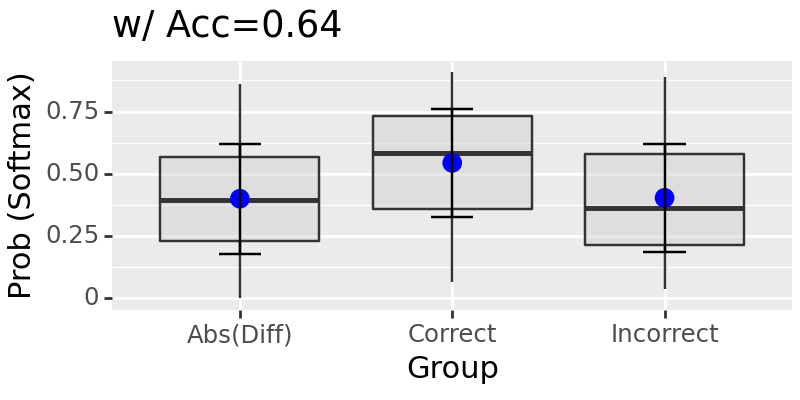


intervening location:  75


Test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:42<00:00,  1.50it/s]


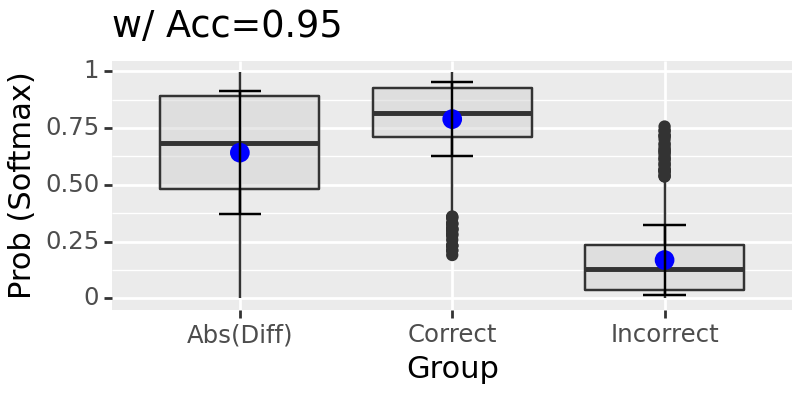


intervening location:  80


Test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:43<00:00,  1.46it/s]


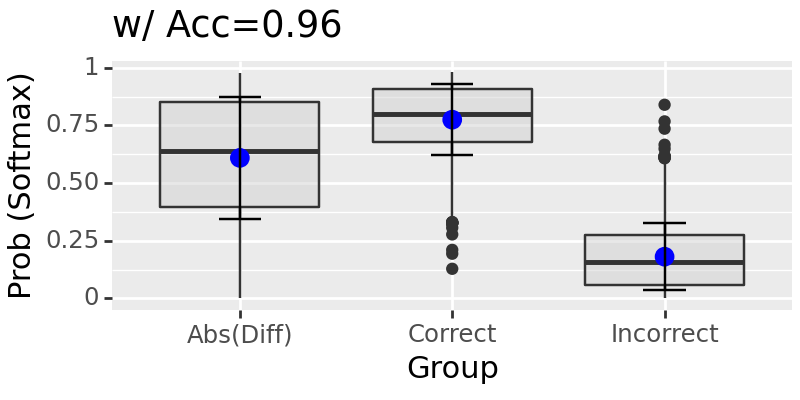


intervening location:  [75, 80]


Test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:09<00:00,  1.10s/it]


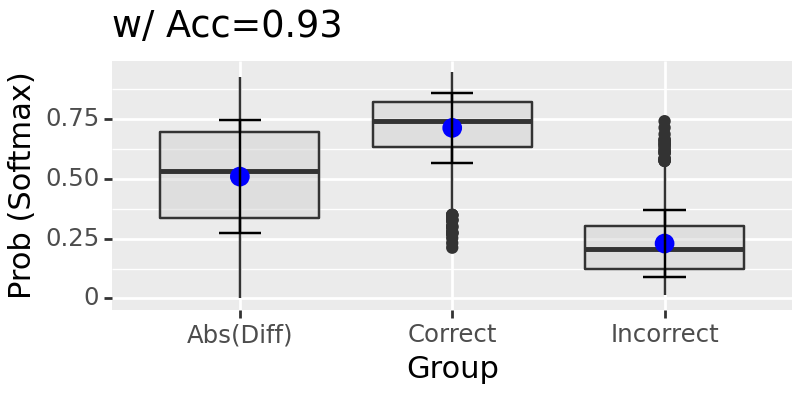

In [144]:
for loc in [78, 75, 80, [75, 80]]:
    if loc == 78:
        print("[control] intervening location: ", loc)
        pv_llama.interventions[f'layer.{layer}.comp.block_output.unit.pos.nunit.1#0'][0].load_state_dict(
            torch.load('./tutorial_data/layer.15.pos.78.bin'))
    else:
        print("intervening location: ", loc)
        pv_llama.interventions[f'layer.{layer}.comp.block_output.unit.pos.nunit.1#0'][0].load_state_dict(
            torch.load('./tutorial_data/layer.15.pos.75.bin'))
    # evaluation on the test set
    collected_probs = []
    eval_labels = []
    eval_preds = []
    with torch.no_grad():
        epoch_iterator = tqdm(test_dataloader, desc=f"Test")
        for step, inputs in enumerate(epoch_iterator):
            for k, v in inputs.items():
                if v is not None and isinstance(v, torch.Tensor):
                    inputs[k] = v.to("cuda")
            b_s = inputs["input_ids"].shape[0]
            if loc == 75 or loc == 78:
                input_sources = [{"input_ids": inputs["source_input_ids"]}, None]
            elif loc == 80:
                input_sources = [None, {"input_ids": inputs["source_input_ids"]}]
            else:
                input_sources = [{"input_ids": inputs["source_input_ids"]}]
            _, counterfactual_outputs = pv_llama(
                {"input_ids": inputs["input_ids"]},
                input_sources, {"sources->base": loc}
            )
            correct_label = inputs["labels"][:,-1]
            incorrect_label = \
                ((correct_label == 8241)*3782 + \
                (correct_label == 3782)*8241).long()
            norm_prob = torch.softmax(
                counterfactual_outputs.logits[:, -1], dim=-1)
            correct_prob = norm_prob[torch.arange(b_s),correct_label].detach().cpu()
            incorrect_prob = norm_prob[torch.arange(b_s),incorrect_label].detach().cpu()
            diff_prob = torch.abs(correct_prob - incorrect_prob)
            collected_probs += [[correct_prob, incorrect_prob, diff_prob]]
            eval_labels += [inputs["labels"]]
            eval_preds += [counterfactual_outputs.logits]
    correct_probs = torch.cat([p[0] for p in collected_probs])
    incorrect_probs = torch.cat([p[1] for p in collected_probs])
    diff_probs = torch.cat([p[2] for p in collected_probs])
    eval_metrics = compute_metrics(eval_preds, eval_labels)

    list1 = correct_probs.tolist()
    list2 = incorrect_probs.tolist()
    list3 = diff_probs.tolist()
    acc = eval_metrics['accuracy']
    df = pd.DataFrame({'Group': ['Correct']*len(list1) + ['Incorrect']*len(list2) + ['Abs(Diff)']*len(list2),
                       'Value': list1 + list2 + list3})
    means = df.groupby('Group')['Value'].mean().reset_index()
    means['ymin'] = means['Value'] - df.groupby('Group')['Value'].std().reset_index()['Value']
    means['ymax'] = means['Value'] + df.groupby('Group')['Value'].std().reset_index()['Value']
    plot = (ggplot(df, aes('Group', 'Value')) +
            geom_boxplot(fill='lightgray', alpha=0.5) +
            geom_point(means, aes('Group', 'Value'), color='blue', size=3) +
            geom_errorbar(means, aes('Group', ymin='ymin', ymax='ymax'), width=0.2) +
            labs(title=f'w/ Acc={acc}', x='Group', y='Prob (Softmax)') +
            theme(figure_size=(4, 2)))
    print(plot)

#### Now, what if we set two aligning intervention sites with contradicting values?

We need to write new data generator since we know want two source examples and these two examples have to result in contrasting behaviors.

In [145]:
def lower_bound_alignment_example_sampler_multisource_non_contradict(
    tokenizer, amount=None, lower_bound=None, bound_width=None
):
    (
        base_lower_bound_sample,
        base_upper_bound_sample,
        _,
    ) = pricing_tag_game_config_sampler(amount, lower_bound, bound_width)
    (
        source_lower_bound_sample,
        source_upper_bound_sample,
        _,
    ) = pricing_tag_game_config_sampler(amount, lower_bound, bound_width)
    (
        source_lower_bound_sample_extra,
        source_upper_bound_sample_extra,
        _,
    ) = pricing_tag_game_config_sampler(amount, lower_bound, bound_width)
    ctf_label_str = random.choice(["Yes", "No"])
    if ctf_label_str == "Yes":
        ctf_label = tokenizer.convert_tokens_to_ids("Yes")
        base_source_regions = [
            [1, 2],
            [1, 3],
            [2, 2],
            [2, 3],
        ]
    elif ctf_label_str == "No":
        ctf_label = tokenizer.convert_tokens_to_ids("No")
        base_source_regions = [[1, 1], [2, 1], [3, 1], [3, 2], [3, 3]]
    base_source_region = random.choice(base_source_regions)
    base_region = base_source_region[0]
    source_region = base_source_region[1]

    base_amount_sample = sample_with_region(
        base_region, base_lower_bound_sample, base_upper_bound_sample
    )
    source_amount_sample = sample_with_region(
        source_region, source_lower_bound_sample, source_upper_bound_sample
    )
    source_amount_sample_extra = sample_with_region(
        source_region, source_lower_bound_sample_extra, source_upper_bound_sample_extra
    )
    return (
        base_lower_bound_sample,
        base_upper_bound_sample,
        source_lower_bound_sample,
        source_upper_bound_sample,
        source_lower_bound_sample_extra, # extra bound
        source_upper_bound_sample_extra, # extra bound
        base_amount_sample,
        source_amount_sample,
        source_amount_sample_extra,      # extra amount
        ctf_label,
        ctf_label_str,
        ctf_label,     # extra label
        ctf_label_str, # extra label
    )

def lower_bound_alignment_example_sampler_multisource_contradict(
    tokenizer, amount=None, lower_bound=None, bound_width=None
):
    (
        base_lower_bound_sample,
        base_upper_bound_sample,
        _,
    ) = pricing_tag_game_config_sampler(amount, lower_bound, bound_width)
    (
        source_lower_bound_sample,
        source_upper_bound_sample,
        _,
    ) = pricing_tag_game_config_sampler(amount, lower_bound, bound_width)
    (
        source_lower_bound_sample_extra,
        source_upper_bound_sample_extra,
        _,
    ) = pricing_tag_game_config_sampler(amount, lower_bound, bound_width)
    ctf_label_str = random.choice(["Yes", "No"])
    if ctf_label_str == "Yes":
        ctf_label = tokenizer.convert_tokens_to_ids("Yes")
        base_source_regions = [
            [1, 2],
            [1, 3],
            [2, 2],
            [2, 3],
        ]
        
    elif ctf_label_str == "No":
        ctf_label = tokenizer.convert_tokens_to_ids("No")
        base_source_regions = [[1, 1], [2, 1]]
        
    base_source_region = random.choice(base_source_regions)
    base_region = base_source_region[0]
    source_region = base_source_region[1]
    if ctf_label_str == "Yes":
        source_extra_region = 1 # flip the left label
        ctf_label_extra = tokenizer.convert_tokens_to_ids("No")
        ctf_label_str_extra = "No"
    elif ctf_label_str == "No":
        source_extra_region = random.choice([2,3]) # flip the left label
        ctf_label_extra = tokenizer.convert_tokens_to_ids("Yes")
        ctf_label_str_extra = "Yes"

    base_amount_sample = sample_with_region(
        base_region, base_lower_bound_sample, base_upper_bound_sample
    )
    source_amount_sample = sample_with_region(
        source_region, source_lower_bound_sample, source_upper_bound_sample
    )
    source_amount_sample_extra = sample_with_region(
        source_region, source_lower_bound_sample_extra, source_upper_bound_sample_extra
    )
    return (
        base_lower_bound_sample,
        base_upper_bound_sample,
        source_lower_bound_sample,
        source_upper_bound_sample,
        source_lower_bound_sample_extra, # extra bound
        source_upper_bound_sample_extra, # extra bound
        base_amount_sample,
        source_amount_sample,
        source_amount_sample_extra,      # extra amount
        ctf_label,
        ctf_label_str,
        ctf_label_extra,     # extra label
        ctf_label_str_extra, # extra label
    )

def bound_alignment_sampler_multisource(
    tokenizer,
    max_n_training_examples,
    bound_functors,
    amount=None,
    lower_bound=None,
    bound_width=None,
):
    all_base_input_ids = []
    all_source_input_ids = []
    all_ctf_output_ids = []  # this one does not have input ids, etc..
    all_intervention_ids = []
    
    all_second_source_input_ids = []
    all_second_ctf_output_ids = []
    
    for _ in range(max_n_training_examples):
        bound_functor = random.choice(bound_functors)
        (
            base_lower_bound_sample,
            base_upper_bound_sample,
            source_lower_bound_sample,
            source_upper_bound_sample,
            source_lower_bound_sample_extra, # extra bound
            source_upper_bound_sample_extra, # extra bound
            base_amount_sample,
            source_amount_sample,
            source_amount_sample_extra,      # extra amount
            ctf_label,
            ctf_label_str,
            ctf_label_extra,     # extra label
            ctf_label_str_extra, # extra label
        ) = bound_functor(
            tokenizer,
            amount,
            lower_bound,
            bound_width,
        )

        base_amount_str = "%.2f dollars" % base_amount_sample
        source_amount_str = "%.2f dollars" % source_amount_sample
        source_amount_str_extra = "%.2f dollars" % source_amount_sample_extra
        base_lower_bound_str = "%.2f" % base_lower_bound_sample
        base_upper_bound_str = "%.2f" % base_upper_bound_sample
        source_lower_bound_str = "%.2f" % source_lower_bound_sample
        source_upper_bound_str = "%.2f" % source_upper_bound_sample
        source_lower_bound_str_extra = "%.2f" % source_lower_bound_sample_extra
        source_upper_bound_str_extra = "%.2f" % source_upper_bound_sample_extra
        # print(f"base: [{base_lower_bound_str}, {base_upper_bound_str}], {base_amount_str}")
        # print(f"source: [{source_lower_bound_str}, {source_upper_bound_str}], {source_amount_str}")
        # print(f"ctf label: {ctf_label_str}")

        base_instruction = f"Please say yes only if it costs between {base_lower_bound_str} and {base_upper_bound_str} dollars, otherwise no."
        source_instruction = f"Please say yes only if it costs between {source_lower_bound_str} and {source_upper_bound_str} dollars, otherwise no."
        source_instruction_extra = f"Please say yes only if it costs between {source_lower_bound_str_extra} and {source_upper_bound_str_extra} dollars, otherwise no."
        
        base_alpaca_prompt = alpaca_prompt_template % (
            base_instruction,
            base_amount_str,
        )
        source_alpaca_prompt = alpaca_prompt_template % (
            source_instruction,
            source_amount_str,
        )
        source_alpaca_prompt_extra = alpaca_prompt_template % (
            source_instruction_extra,
            source_amount_str_extra,
        )
        
        base_input_ids = tokenizer(base_alpaca_prompt, return_tensors="pt").input_ids[0]
        source_input_ids = tokenizer(
            source_alpaca_prompt, return_tensors="pt"
        ).input_ids[0]
        source_input_ids_extra = tokenizer(
            source_alpaca_prompt_extra, return_tensors="pt"
        ).input_ids[0]
        
        base_input_ids = base_input_ids.tolist()
        source_input_ids = source_input_ids.tolist()
        source_input_ids_extra = source_input_ids_extra.tolist()
        
        ctf_output_ids = (torch.ones(len(base_input_ids)) * -100).long().tolist()
        ctf_output_ids[-1] = ctf_label
        ctf_output_ids_extra = (torch.ones(len(base_input_ids)) * -100).long().tolist()
        ctf_output_ids_extra[-1] = ctf_label_extra
        intervention_id = 0 if bound_functor == bound_functors[0] else 1

        all_base_input_ids += [base_input_ids]
        all_source_input_ids += [source_input_ids]
        all_second_source_input_ids += [source_input_ids_extra]

        all_ctf_output_ids += [ctf_output_ids]
        all_second_ctf_output_ids += [ctf_output_ids_extra]
        all_intervention_ids += [intervention_id]

        assert len(base_input_ids) == 82
        assert len(source_input_ids) == 82

    return (
        all_base_input_ids,
        all_source_input_ids,
        all_second_source_input_ids,
        all_ctf_output_ids,
        all_second_ctf_output_ids,
        all_intervention_ids,
    )


In [146]:
multisource_non_contradict_test_data = bound_alignment_sampler_multisource(
    tokenizer, 1000, [lower_bound_alignment_example_sampler_multisource_non_contradict]
)
multisource_contradict_test_data = bound_alignment_sampler_multisource(
    tokenizer, 1000, [lower_bound_alignment_example_sampler_multisource_contradict]
)
multisource_non_contradict_test_dataset = Dataset.from_dict(
    {
        "input_ids": multisource_non_contradict_test_data[0],
        "source_input_ids": multisource_non_contradict_test_data[1],
        "second_source_input_ids": multisource_non_contradict_test_data[2],
        "labels": multisource_non_contradict_test_data[3],
        "second_labels": multisource_non_contradict_test_data[4],
        "intervention_ids": multisource_non_contradict_test_data[5],  # we will not use this field
    }
).with_format("torch")
multisource_non_contradict_test_dataloader = DataLoader(multisource_non_contradict_test_dataset, batch_size=16)

multisource_contradict_test_dataset = Dataset.from_dict(
    {
        "input_ids": multisource_contradict_test_data[0],
        "source_input_ids": multisource_contradict_test_data[1],
        "second_source_input_ids": multisource_contradict_test_data[2],
        "labels": multisource_contradict_test_data[3],
        "second_labels": multisource_contradict_test_data[4],
        "intervention_ids": multisource_contradict_test_data[5],  # we will not use this field
    }
).with_format("torch")
multisource_contradict_test_dataloader = DataLoader(multisource_contradict_test_dataset, batch_size=16)

[control] swapping two sources with the same counterfactual behavior


Test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:04<00:00,  1.02s/it]


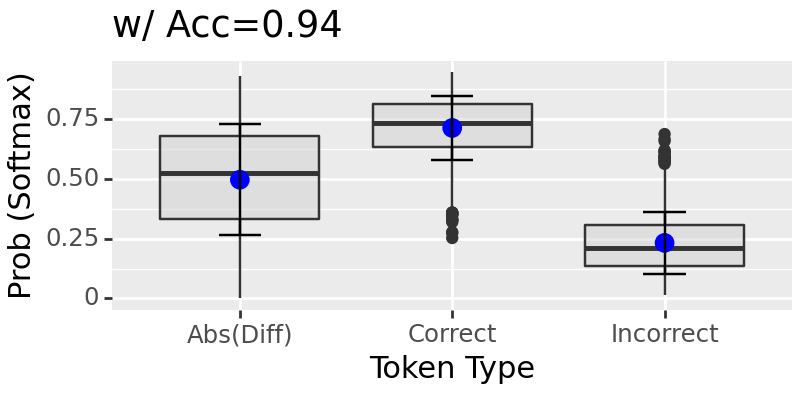


swapping contradicting sources, and evaluate with matching location 75


Test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:07<00:00,  1.07s/it]


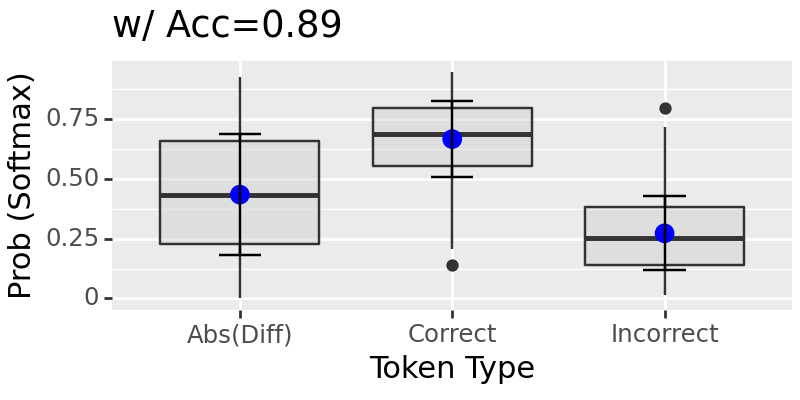


swapping contradicting sources, and evaluate with matching location 80


Test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [01:09<00:00,  1.10s/it]


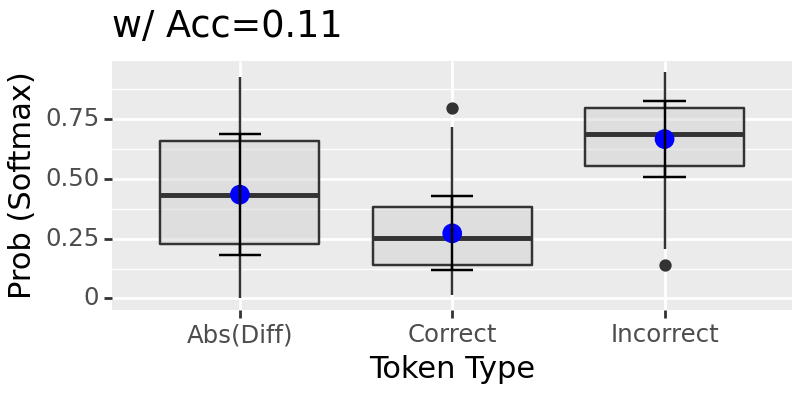

In [158]:
print("[control] swapping two sources with the same counterfactual behavior")
for testing_label in ["labels"]:
    collected_probs = []
    eval_labels = []
    eval_preds = []
    with torch.no_grad():
        epoch_iterator = tqdm(multisource_non_contradict_test_dataloader, desc=f"Test")
        for step, inputs in enumerate(epoch_iterator):
            for k, v in inputs.items():
                if v is not None and isinstance(v, torch.Tensor):
                    inputs[k] = v.to("cuda")
            b_s = inputs["input_ids"].shape[0]
            input_sources = [
                {"input_ids": inputs["source_input_ids"]},
                {"input_ids": inputs["second_source_input_ids"]}
            ]
            _, counterfactual_outputs = pv_llama(
                {"input_ids": inputs["input_ids"]},
                input_sources, {"sources->base": [75, 80]}
            )
            correct_label = inputs[testing_label][:,-1]
            incorrect_label = \
                ((correct_label == 8241)*3782 + \
                (correct_label == 3782)*8241).long()
            norm_prob = torch.softmax(
                counterfactual_outputs.logits[:, -1], dim=-1)
            correct_prob = norm_prob[torch.arange(b_s),correct_label].detach().cpu()
            incorrect_prob = norm_prob[torch.arange(b_s),incorrect_label].detach().cpu()
            diff_prob = torch.abs(correct_prob - incorrect_prob)
            collected_probs += [[correct_prob, incorrect_prob, diff_prob]]
            eval_labels += [inputs[testing_label]]
            eval_preds += [counterfactual_outputs.logits]
    correct_probs = torch.cat([p[0] for p in collected_probs])
    incorrect_probs = torch.cat([p[1] for p in collected_probs])
    diff_probs = torch.cat([p[2] for p in collected_probs])
    eval_metrics = compute_metrics(eval_preds, eval_labels)

    list1 = correct_probs.tolist()
    list2 = incorrect_probs.tolist()
    list3 = diff_probs.tolist()
    acc = eval_metrics['accuracy']
    df = pd.DataFrame({'Group': ['Correct']*len(list1) + ['Incorrect']*len(list2) + ['Abs(Diff)']*len(list2),
                       'Value': list1 + list2 + list3})
    means = df.groupby('Group')['Value'].mean().reset_index()
    means['ymin'] = means['Value'] - df.groupby('Group')['Value'].std().reset_index()['Value']
    means['ymax'] = means['Value'] + df.groupby('Group')['Value'].std().reset_index()['Value']
    plot = (ggplot(df, aes('Group', 'Value')) +
            geom_boxplot(fill='lightgray', alpha=0.5) +
            geom_point(means, aes('Group', 'Value'), color='blue', size=3) +
            geom_errorbar(means, aes('Group', ymin='ymin', ymax='ymax'), width=0.2) +
            labs(title=f'w/ Acc={acc}', x='Token Type', y='Prob (Softmax)') +
            theme(figure_size=(4, 2)))
    print(plot)
    
for testing_label in ["labels", "second_labels"]:
    if testing_label == "labels":
        print("swapping contradicting sources, and evaluate with matching location 75")
    elif testing_label == "second_labels":
        print("swapping contradicting sources, and evaluate with matching location 80")
    collected_probs = []
    eval_labels = []
    eval_preds = []
    with torch.no_grad():
        epoch_iterator = tqdm(multisource_contradict_test_dataloader, desc=f"Test")
        for step, inputs in enumerate(epoch_iterator):
            for k, v in inputs.items():
                if v is not None and isinstance(v, torch.Tensor):
                    inputs[k] = v.to("cuda")
            b_s = inputs["input_ids"].shape[0]
            input_sources = [
                {"input_ids": inputs["source_input_ids"]},
                {"input_ids": inputs["second_source_input_ids"]}
            ]
            _, counterfactual_outputs = pv_llama(
                {"input_ids": inputs["input_ids"]},
                input_sources, {"sources->base": [75, 80]}
            )
            correct_label = inputs[testing_label][:,-1]
            incorrect_label = \
                ((correct_label == 8241)*3782 + \
                (correct_label == 3782)*8241).long()
            norm_prob = torch.softmax(
                counterfactual_outputs.logits[:, -1], dim=-1)
            correct_prob = norm_prob[torch.arange(b_s),correct_label].detach().cpu()
            incorrect_prob = norm_prob[torch.arange(b_s),incorrect_label].detach().cpu()
            diff_prob = torch.abs(correct_prob - incorrect_prob)
            collected_probs += [[correct_prob, incorrect_prob, diff_prob]]
            eval_labels += [inputs[testing_label]]
            eval_preds += [counterfactual_outputs.logits]
    correct_probs = torch.cat([p[0] for p in collected_probs])
    incorrect_probs = torch.cat([p[1] for p in collected_probs])
    diff_probs = torch.cat([p[2] for p in collected_probs])
    eval_metrics = compute_metrics(eval_preds, eval_labels)

    list1 = correct_probs.tolist()
    list2 = incorrect_probs.tolist()
    list3 = diff_probs.tolist()
    acc = eval_metrics['accuracy']
    df = pd.DataFrame({'Group': ['Correct']*len(list1) + ['Incorrect']*len(list2) + ['Abs(Diff)']*len(list2),
                       'Value': list1 + list2 + list3})
    means = df.groupby('Group')['Value'].mean().reset_index()
    means['ymin'] = means['Value'] - df.groupby('Group')['Value'].std().reset_index()['Value']
    means['ymax'] = means['Value'] + df.groupby('Group')['Value'].std().reset_index()['Value']
    plot = (ggplot(df, aes('Group', 'Value')) +
            geom_boxplot(fill='lightgray', alpha=0.5) +
            geom_point(means, aes('Group', 'Value'), color='blue', size=3) +
            geom_errorbar(means, aes('Group', ymin='ymin', ymax='ymax'), width=0.2) +
            labs(title=f'w/ Acc={acc}', x='Token Type', y='Prob (Softmax)') +
            theme(figure_size=(4, 2)))
    print(plot)

#### The results above show if two intervention sites take on contradicting values, it will trust the earlier site. 
It is hard to say if this would hold till more tests. However, we can see the neural network shows some voting mechanism by trusting some location over another during interventions when these locations take different values. If they have the same value, it seems to working well.

##### Minor: make sure other control models cannot find good alignments
We test this by training Boundless DAS with the best locations in the paper: layer 15 and last token (81th).

In [13]:
control_sampler = bracket_alignment_sampler

In [14]:
set_seed(42)

###################
# data loaders
###################
raw_data = control_sampler(
    tokenizer, 10000,
)

raw_train = (
    raw_data[0][:8000],
    raw_data[1][:8000],
    raw_data[2][:8000],
    raw_data[3][:8000],
)
raw_eval = (
    raw_data[0][8000:9000],
    raw_data[1][8000:9000],
    raw_data[2][8000:9000],
    raw_data[3][8000:9000],
)
raw_test = (
    raw_data[0][9000:],
    raw_data[1][9000:],
    raw_data[2][9000:],
    raw_data[3][9000:],
)
train_dataset = Dataset.from_dict(
    {
        "input_ids": raw_train[0],
        "source_input_ids": raw_train[1],
        "labels": raw_train[2],
        "intervention_ids": raw_train[3],  # we will not use this field
    }
).with_format("torch")
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
)
eval_dataset = Dataset.from_dict(
    {
        "input_ids": raw_eval[0],
        "source_input_ids": raw_eval[1],
        "labels": raw_eval[2],
        "intervention_ids": raw_eval[3],  # we will not use this field
    }
).with_format("torch")
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=16,
)
test_dataset = Dataset.from_dict(
    {
        "input_ids": raw_test[0],
        "source_input_ids": raw_test[1],
        "labels": raw_test[2],
        "intervention_ids": raw_test[3],  # we will not use this field
    }
).with_format("torch")
test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
)

In [15]:
layer = 15
token_position = 81

In [16]:
pv_config = pv.IntervenableConfig(
    representations=[
        pv.RepresentationConfig(
            layer, "block_output"
        )],
    intervention_types=pv.BoundlessRotatedSpaceIntervention,
)
pv_llama = pv.IntervenableModel(pv_config, llama)
pv_llama.set_device("cuda")
pv_llama.disable_model_gradients()

epochs = 1
gradient_accumulation_steps = 4
total_step = 0
t_total = int(len(train_dataloader) * epochs)
temperature_start = 50.0
temperature_end = 0.1
temperature_schedule = (
    torch.linspace(
        temperature_start, temperature_end, t_total
    )
    .to(torch.bfloat16)
    .to("cuda")
)
pv_llama.set_temperature(temperature_schedule[total_step])

warm_up_steps = 0.1 * t_total
optimizer_params = []
for k, v in pv_llama.interventions.items():
    optimizer_params += [
        {"params": v[0].rotate_layer.parameters()}]
    optimizer_params += [
        {"params": v[0].intervention_boundaries, "lr": 1e-2}]
optimizer = torch.optim.Adam(optimizer_params, lr=1e-3)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warm_up_steps,
    num_training_steps=t_total
)

def calculate_loss(logits, labels):
    shift_logits = logits[..., :, :].contiguous()
    shift_labels = labels[..., :].contiguous()
    # Flatten the tokens
    loss_fct = CrossEntropyLoss()
    shift_logits = shift_logits.view(-1, config.vocab_size)
    shift_labels = shift_labels.view(-1)
    # Enable model parallelism
    shift_labels = shift_labels.to(shift_logits.device)
    loss = loss_fct(shift_logits, shift_labels)

    for k, v in pv_llama.interventions.items():
        boundary_loss = 1.0 * v[0].intervention_boundaries.sum()
    loss += boundary_loss

    return loss

In [17]:
pv_llama.model.train()  # train enables drop-off but no grads
print("llama trainable parameters: ", count_parameters(pv_llama.model))
print("intervention trainable parameters: ", pv_llama.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")
for epoch in train_iterator:
    epoch_iterator = tqdm(
        train_dataloader, 
        desc=f"Epoch: {epoch}", position=0, leave=True
    )
    for step, inputs in enumerate(epoch_iterator):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cuda")
        b_s = inputs["input_ids"].shape[0]
        _, counterfactual_outputs = pv_llama(
            {"input_ids": inputs["input_ids"]},
            [{"input_ids": inputs["source_input_ids"]}],
            {"sources->base": token_position},
        )
        eval_metrics = compute_metrics(
            [counterfactual_outputs.logits], [inputs["labels"]]
        )

        # loss and backprop
        loss = calculate_loss(counterfactual_outputs.logits, inputs["labels"])
        loss_str = round(loss.item(), 2)
        epoch_iterator.set_postfix({"loss": loss_str, "acc": eval_metrics["accuracy"]})

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            if not (gradient_accumulation_steps > 1 and total_step == 0):
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                pv_llama.set_temperature(
                    temperature_schedule[total_step])
        total_step += 1

llama trainable parameters:  0
intervention trainable parameters:  16777218


Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [13:18<00:00, 798.36s/it]


In [11]:
# evaluation on the test set
eval_labels = []
eval_preds = []
with torch.no_grad():
    epoch_iterator = tqdm(test_dataloader, desc=f"Test")
    for step, inputs in enumerate(epoch_iterator):
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to("cuda")
        b_s = inputs["input_ids"].shape[0]
        _, counterfactual_outputs = pv_llama(
            {"input_ids": inputs["input_ids"]},
            [{"input_ids": inputs["source_input_ids"]}],
            {"sources->base": 75}
        )
        eval_labels += [inputs["labels"]]
        eval_preds += [counterfactual_outputs.logits]
eval_metrics = compute_metrics(eval_preds, eval_labels)
print(eval_metrics)

Test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:43<00:00,  1.46it/s]

{'accuracy': 0.68}
